| <div align="left"> <a href="https://github.com/marashot96/Credit-Products-Analysis/blob/main/notebooks/Navigator.md">🔙 Назад к Jupyter-notebooks </a>  </div> | | <div align="center">  <a href="https://github.com/marashot96/portfolio/blob/main/README.md#-реализованные-проекты">🔙 Мое полное портфолио </a> </div> | | <div align="right"> <a href="https://github.com/marashot96/Credit-Products-Analysis?tab=readme-ov-file#-czech-bank-project--">🔙 Назад к описанию проекта </a>  </div> |
| ---- | -------- | ----- | ---------------- | ------ |

# <div align="center"> Модель предсказания дефолта по кредиту </div>

В этом ноутбуке обучается простая модель машинного обучения, предсказывающая вероятность дефолта клиента на основе информации о кредите, клиенте и активности.

Целевая переменная — статус кредита: `B` (невыплачен вовремя) — считается дефолтом.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Загрузка данных
client = pd.read_csv('CLIENT.csv', sep=';')
disp = pd.read_csv('DISP.csv', sep=';')
account = pd.read_csv('ACCOUNT.csv', sep=';')
loan = pd.read_csv('LOAN.csv', sep=';')
trans = pd.read_csv('TRANS.csv', sep=';')

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Подготовка датасета

Формируем обучающий набор, объединяя данные о клиенте, счёте и кредите. Добавим признаки возраста, размера кредита, активности и средней транзакции.

In [2]:
# Возраст клиента
client['birth_year'] = client['birth_number'] // 10000 + 1900
client['age'] = 1999 - client['birth_year']

# Инфо по кредитам
loan_acc = loan.merge(account[['account_id', 'district_id']], on='account_id', how='left')
loan_disp = disp[disp['type'] == 'OWNER'].merge(loan_acc, on='account_id', how='right')
loan_data = loan_disp.merge(client, on='client_id', how='left')

# Активность по транзакциям
trans_count = trans.groupby('account_id')['amount'].agg(['count', 'mean']).reset_index()
trans_count.columns = ['account_id', 'num_trans', 'avg_amount']
loan_data = loan_data.merge(trans_count, on='account_id', how='left')

# Заполнение пропусков
loan_data['num_trans'] = loan_data['num_trans'].fillna(0)
loan_data['avg_amount'] = loan_data['avg_amount'].fillna(0)

# Целевая переменная
loan_data['target'] = (loan_data['status'] == 'B').astype(int)


## Обучение модели логистической регрессии

Выбираем числовые признаки и делим выборку на обучающую и тестовую.

In [3]:
features = ['age', 'amount', 'duration', 'payments', 'num_trans', 'avg_amount']
X = loan_data[features]
y = loan_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

## Оценка точности модели

Обучаем логистическую регрессию и смотрим на качество классификации.


In [4]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Метрики
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[163   0]
 [  8   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       163
           1       0.00      0.00      0.00         8

    accuracy                           0.95       171
   macro avg       0.48      0.50      0.49       171
weighted avg       0.91      0.95      0.93       171


ROC-AUC: 0.5628834355828221


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Важность признаков

Анализ коэффициентов модели — какие признаки влияют на вероятность дефолта.


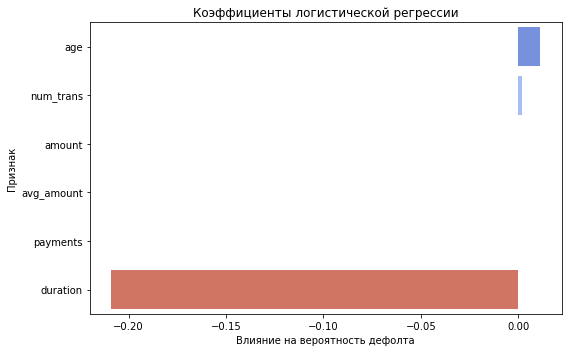

In [5]:
coeff_df = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_[0]})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Coefficient', y='Feature', data=coeff_df, palette='coolwarm')
plt.title('Коэффициенты логистической регрессии')
plt.xlabel('Влияние на вероятность дефолта')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

## Выводы

- Модель выявляет клиентов с повышенным риском дефолта на основе размера кредита, активности и возраста.
- Важнейшие признаки: `duration`, `age`.
- Можно расширить модель, добавив категориальные признаки (частота, регион и т.п.).

---

## 💼 Контактная информация
Если вы хотите обсудить различные задачи, запросы или проекты, предложить кейс или сотрудничество — обязательно напишите мне!

- 📫 [t.me/marashot96](https://t.me/marashot96)
- 🌐 [marashot96@ya.ru](mailto:marashot96@ya.ru)

| <div align="left"> <a href="https://github.com/marashot96/Credit-Products-Analysis/blob/main/notebooks/Navigator.md">🔙 Назад к Jupyter-notebooks </a>  </div> | | <div align="center">  <a href="https://github.com/marashot96/portfolio/blob/main/README.md#-реализованные-проекты">🔙 Мое полное портфолио </a> </div> | | <div align="right"> <a href="https://github.com/marashot96/Credit-Products-Analysis?tab=readme-ov-file#-czech-bank-project--">🔙 Назад к описанию проекта </a>  </div> |
| ---- | -------- | ----- | ---------------- | ------ |
